# Machine Learning 530

## Introduction to Convolutional Neural Networks

### Expanded and Modified by Jerry Kuch, Based on an Exercise by Steve Elston

## 1.0 Introduction to convolutional neural networks

This lesson introduces you to a powerful neural network architecture, known as **convolutional neural networks**. Convolutional neural networks operate by **learning a set of filters**  or **convolution kernels**. Using a process, known as **convolution**, these filters extract a **feature map** from the raw data. The feature map is a **lower dimensional** map of the raw input features. This map is learned in a supervised machine learning process employing back-propagation. You can think of convolutional neural networks as a powerful and flexible **dimensionality reduction** method.

Convolutional neural networks are used to build feature maps from any type of data that exhibits local spatial coherency in one or more dimensions. Examples include time series data and text data in one dimension, and image data in two dimensions.

Convolutional neural networks have a resonably long history. The first known commerical application was for automated processing of check images by LeCun et. al. (1998). For unclear reasons, convolutional neural networks were relegated to specialized applications such as hand writing recognition until Krizhevsky et. al. (2012) used them to decisively win an ImageNet object recognition competition. Curiously, other teams had previously used convolutional neural networks to win competitons, but somehow this was not widely recognized.

In this lesson you will learn:
1. The basics of convolutional neural network architecture.
2. How convolutional neural networks learn the filters to create the feature map.
3. Feature extraction for creating the feature map.
4. Visualization of the feature map and the filters.
5. Commonly used convolutional operator design.
6. How to use the feature map in supervised learning.

****
**Note:** The formulation of convolution filters used in deep learning is somewhat idiosycratic. If you are familar with the standard approach as seen in electrical engineering or control engineering you may find the approach used here a bit different. We'll probably have said a bit more about the difference in class by this point, but for the purposes of almost all applied deep learning with convolutional methods, the variation used here, and discussed in class, is what you'll be thinking about.
****   

To start, execute the code in the cell below to import the packages and functions you will need for this notebook.

In [ ]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt

import keras
import tensorflow

from keras.datasets import mnist

import keras.utils.np_utils as ku

import keras.models as models
import keras.layers as layers

from keras import regularizers
from keras.layers import Dropout
from keras import optimizers

%matplotlib inline

### 1.1 Applying 2-d convolution

Let's review how we can apply convolution operations in two dimensions. We saw examples of how a convolution can be applied to a 2D input array, such as a gray-scale image.

Suppose we apply a $3\times 3$ convolutional operator to a small image  $4\times 4$ pixels in size. Within the $4\times 4$ image the operator is only applied four times, i.e. at each place where the complete operator kernel can lie on the image. Convolution where the operator is completely contained within the input sample, i.e. only positioned at locations that are within the boundaries of the original image under consideration, are sometimes called called **valid** convolutions.

In the above case the $4\times 4$ pixel input results in a $2\times 2$ pixel output. You can think of the convolutional operator mapping from the center of the operator's position on the input to a pixel in the output. Similar to the 1D case, for a convolution operator with side length $k$ in both dimensions the output array will be reduced in each dimension by $\frac{k + 1}{2}$.

**NOTE:** I find it easiest to just keep the formula $\big\lfloor {n + 2\cdot p - k \over s }\big\rfloor +1$ for the edge size of the resulting image handy.  In the formula, $n$ is the side length of the target image, $k$ is the side length of the filter kernel, $p$ is the number of pixels of edge padding on a single edge, and $s$ is the stride with which we advance the kernel across the input.  Remembering this formula, will save you having to reason out the effects of individual parameters associated with the convolution's application, make it quick to figure out the output dimensions of a given operation, etc.

We can write the convolution operation in 2D as follows:

$$S(i,j) = (I * K)(i,j) = \sum_m \sum_n I(m, n) K(i-m, j-n)$$

Notice that $S$, $I$ and $K$ are all tensors, representing the result of the convolution, the input image, and the filter kernel respectively.  The bounds of the sum are as needed to sum over all the points of the kernel.

A proper convolution commutes, i.e. we can swap the order of the filter kernel $K$ and the image $I$ and get an equivalent representation as follows:

$$S(i,j) = (K * I)(i,j) = \sum_m \sum_n I(i-m, j-n) K(m, n)$$

As we mentioned in class the notion of convolution that is most often used in deep learning is a bit different from the one you may have seen in signals and systems, signal processing, controls, or other such fields.  The version we use in deep learning is really a *cross-correlation* and loses the nice commutativity property which requires the kernel to be mirrored horizontally and vertically before we do the arithmetic we saw in class.  The commutative property makes the algebra of certain proofs easier, and is used more naturally and heavily in those other fields mentioned above, but commutativity isn't usually important in implementing neural networks.  If you wanted to write the formula for the cross-correlation you'd replace the minus signs in the formulas above with plus signs.

**KEY REMARK:** Don't let the above sums or formulas startle or jar you, if they seem complicated or unfamiliar.  Just remember what we computed by hand in class, realize that in practice a library is going to do the arithmetic for you on a computer, and that the formulas are mainly useful for following proofs or arguments, or implementing libraries from scratch.  Also, remember that deep learning convolutions aren't really quite convolutions as many other people think of the term.

### 1.2 Convolution in higher dimensions

In deep convolutional neural networks the input typically has several **input channels** with the convolution operation resulting in multiple **output channels**.

So far, we have mostly looked at single channel convolution, though in class we should by now have covered how things work when we have multiple input channels, i.e. the input isn't just a "flat" matrix, but is instead a thicker "slab", i.e. a higher dimensional array.

Here are some examples of input tensors with different numbers of input channels:
- A gray-scale image has a single input channel of pixels.
- A color image typically has 3 input channels, {Red, Green, Blue}.
- A color movie has a large number of input channels. For $n$ images in the video there are $3 * n$ images counting the Red, Green, Blue channels for each image.  

The purpose of a convolutional neural network is to create a feature map. To create the most general feature map, convolution operators need not be restricted to a single input channel. As we learn the parameters of a convolutional kernel, phenomena seen in different channels may impact different parameters of different kernels based on how back-propagation drives them.

Further, the feature map can have many channels, resulting in multiple output channels. Each channel is a set of features extracted from the input tensor. We illustrated the idea in class, showing examples where a set of convolution operators transform the input tensors to multiple channels of the feature map in the next layer. Each convolution operator maps to a specific output channel in the feature map.

**NOTE:** If all the summations and indices are making you snowblind at this point, don't worry about them. Think back to the sort of calculations we showed by hand in class, make sure you have those in your bones, and come back to the formulas at your leisure, if you want, to convince yourself the formulas are just a recipe for that thing we did by hand.

### 1.3 Parameter sharing and sparse interactions

**Parameter sharing** and **sparse interactions** are two powerful aspects of convolutional neural networks. To understand what these terms mean and why they are important, consider the fully connected neural networks we saw in class.

Needing each of the units in one layer to connect to every unit in the subsequent layer means that a fully connected neural network will have a large number of weights.  Between a layer with $M$ units and a layer with $N$ units, there need to be $MN$ connections for full connectivity.

When dealing with images, which may contain hundreds, thousands, or millions of pixels, such *dense connections* would lead to untenably large numbers of weights, as discussed in class. Parameter sharing is also sometimes referred to as **tied weights** and is an example of a **sparse interaction** between layers.

The shared nature of the parameters in convolutional neural networks is a significant reduction in complexity. Statistically, such a sparse model is said to **share statistical strength**. This statistical strength results in model weights with less uncertainty and a model less likely to be overfit.

The computational efficiency of convolutional neural networks is not just in training. Convolutional neural networks are also efficient for creating **rich feature maps** which lead to high levels of accuracy in production.

### 1.4 Pooling and invariance

To further reduce dimensionality and to make the feature map robust to small shifts in the input, **pooling** is applied following the nonlinear detection stage. Pooling involves applying an aggregation function to patches of the output from the nonlinear detector of a convolution layer.  Note that the order in which the pooling and the nonlinear activation is applied varies from model to model and author to author.  For some combinations of pooling and activation functions it doesn't matter, as the operations commute. For example, if your nonlinear acivation is a *monotone increasing* function, that activation will commute with max pooling.

Researchers have tried a number of pooling schemes. In practice **max pooling** (Zhou and Chellappa, 1988) has proved to be both robust and versatile. In max pooling the output value is just the maximum of the input values in each patch.  You may also see references to or usages of **average pooling** where the output pixel is the average of the pixel values in some neighborhood of the input layer.

Unlike convolutional layers, *there are no parameters to learn in pooling layers*, which makes back-propagation across them trivial.

Max pooling has the nice property of being robust to small shifts in the input values. If an input pixel shifts just a little bit, but stays within the granularity of the pooling, the next layer is unlikely to perceive much difference.  Consult the discussion in class or Chapter 8 of Chollet if you want to review the details.

> **Exercise 2-1:** You will now undertake an exercise to better understand the effects of max pooling. To simplify this exercise you will work with 1-dimensional data and **edge detection** operators. Do the following:   
> 1. Create a function named `max_pool` that moves a maximum of the absolute value operator with a span of 3 and stride of 2 over the input series.  In other words, under a window of three input elements, compute the absolute value of those elements, take the largest of those, and yield that single value as your output for that window. For simplicity start the operator at the beginning of the data series.     
> 2. Create two edge detection convolutional kernels, $kernel1 = [-0.5, 1.0, -0.5]$ and $kernel2 = [0.5, -1.0, 0.5]$.  You might want to pause and think about why these kernels would get excited on edges in the 1D signal we're looking at.
> 3. Apply both of the convolution kernels to the `series1` data provided using the [numpy.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) function. Assign these two results to separate variables as shown.
> 4. Apply your `max_pool` function to the convolution result series. Assign these two results to different variables.    
> 5. Display the results comparing the convolution series to the max-pooled series using the `plot_pool` function provided.

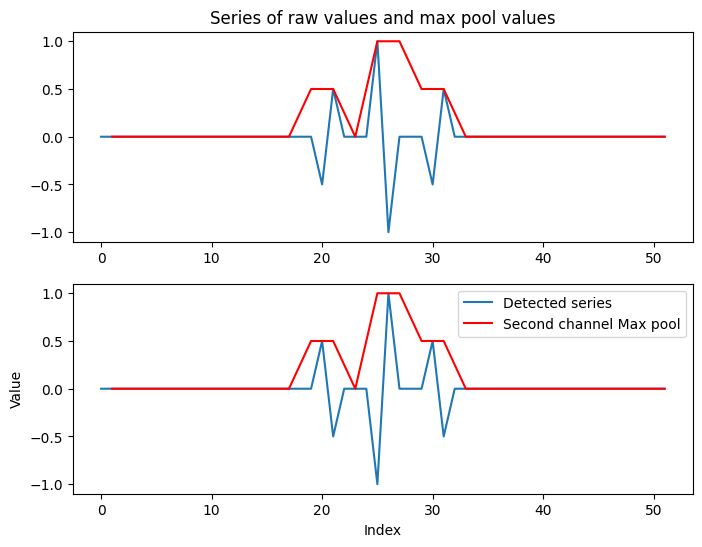

In [ ]:
def plot_pool(series1, series2, pool1, pool2):
    x = list(range(series1.shape[0]))
    end = series1.shape[0]
    fig = plt.figure(figsize=(8,6))
    ## First channel
    plt.subplot(2, 1, 1)
    plt.plot(x, series1, label = 'Detected series')
    plt.plot(x[1:end:2], pool1, color = 'red', label = 'First channel max pool')
    plt.title('Series of raw values and max pool values')
    ## Second channel
    plt.subplot(2, 1, 2)
    plt.plot(x, series2, label = 'Detected series')
    plt.plot(x[1:end:2], pool2, color = 'red', label = 'Second channel Max pool')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')

nr.seed(12233)
series1 = np.concatenate((np.zeros((20,)), np.zeros((5,)) + 1.0, np.zeros((5,)) - 1.0, np.zeros((20,))))

## Your code goes below, see TODOs
def max_pool(series, span=3):
    '''Performs simple 1d max pooling with
    an operator span of 2 and stride 2'''
    out =[]
    n = len(series) #TODO
    for i in range(0, n - 1, span-1):
      #TODO
      temp = list(map(lambda x: abs(x), series[i:i+span]))
      # append absolute value or original values?
      out.append(max(temp))
    return np.array(out)

kernel1 = [-0.5,1.0,-0.5] # TODO
kernel2 = [0.5,-1.0,0.5] # TODO
result1 = np.convolve(series1, kernel1) #TODO
result2 = np.convolve(series1, kernel2) #TODO

pool1 = max_pool(result1) #TODO
pool2 = max_pool(result2) #TODO

plot_pool(result1, result2, pool1, pool2)

If all went well above, you should see a blue curve that does a couple of aggressive oscillations at the places where the edges (abrupt steps up or down) were present in the input `series1`.  Those oscillations are what your edge detection kernel "discovered" at the positions of the edges in the original signal.

The red curve, representing the "max of absolute value over the window" pooling you implemented should produce nonzero outputs centered around where the step edges were in the original `series1` (which we did not plot).  You should see it as sort of an envelope, loosely wrapping the more granular, higher frequency changes going on in the blue curve.  In a way you can think of it as summarizing them by catching the key element of the behavior (something is happening here), without all the high resolution detail (there's multiple bounces in the blue curve here).

Thus you should see that this particular notion of pooling *downsampled* a signal containing some fine or high frequency detail into something with less resolution, but where features of interest were still preserved in some form in roughly the area where they occurred.

This pooling operator isn't *quite* any of the ones we saw in class, but it's fairly easy to implement, visualizable in action, and should hopefully give you a bit more supporting intuition for the idea.

> Examine these results and answer these questions:   
> 1. How does the max-pooling operator preserve edges in the convolution output series?
> 2. How can you explain the invariance of the max-pooling result to the sign of the input series.  
> **End of exercise**.   

> **Answers:**
> 1. By selecting the most prominent features i.e. the max of the absolute values from each region/span in the series
> 2. Because max-pooling uses absolute values of the input series.

### 1.7 Stride and tiling

Up until now, we have only moved the convolution operator one pixel at a time. There is no restriction that requires this type of step, however. In fact, a convolutional operator or pooling operator can be moved by several pixels in any direction. This step size is known as the **stride** of the operator.

Operators with stride greater than one will **decimate** the number of pixels in the output. This can be useful when resizing images of different dimensions so they have constant input dimensions for a neural network.

Using an operator with $stride = span$ is a special case known as **tiling**. Tiled operators are layed out without any overlap. Thus if we had an input of dimensions $6\times 6$, it would be tiled by operators with dimension $3\times 3$ with stride of 3. Only 4 tiles fit on the input in this case, resulting in a $4\times 4$ output array.


## 2.0 Convolutional neural networks with Keras

With the foregoing theory and simple examples, let's try constructing and testing a convolutional neural network using Keras. In this case, we will test classification of of the MNIST dataset. The neural network will have the following layers:
1. An input layer for the $28\times 28$ images.
2. A multi-layer convolutional neural network to create a feature map.
3. A fully-connected hidden layer to perform the classification.
4. A output layer to indicate which digit is most likely.

### 2.1 Preparing the dataset

The preparation of this dataset is follows nearly identical steps to the process followed in an earlier lesson. In summary, three preparation steps are performed:
1. Load the training and test image data and labels.
2. Reshape the image tensors so the neural network views them as a 4-d tensor. For the training images the tensor has a shape of (60000,28,28,1) corresponding to 60000 images of dimension $28 \times 28$ with a single channel (these are gray-scale images). At the same time the pixel values are converted to `float` type in the range $\{ 0,1 \}$.
3. The labels are recoded as dummy variables using the Keras [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float')/255
print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28, 1)
float64


In [ ]:
print(test_images.shape, test_labels.shape)
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float')/255
print(test_images.shape)

(10000, 28, 28) (10000,)
(10000, 28, 28, 1)


In [ ]:
train_labels = ku.to_categorical(train_labels)
print(train_labels[5:,])

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
test_labels = ku.to_categorical(test_labels)

### 2.2 Defining the model.

It is now time to define the model.

As a first step, the callbacks required to implement early stopping regularization are defined. The steps are:    
1. Define a path to an HDF5 file used to save the best version of the model seen so far during training.
2. The first callback stops the training when the validation loss does not improve after 4 consecutive epochs, a parameter called the *patience*.
3. The second callback saves the model weights resulting from the epoch with the best validation loss seen so far.

In [ ]:
## Set up and call-backs for early stopping
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Monitor validation loss to determine when to stop
            patience = 4 # Number of epochs with no improvement after which training will be stopped
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is better
            save_best_only = True # Only save model if it is the best
        )
]


> **Exercise 2-2:** You will now use Keras to define the ConvNet model named `nn`. This model uses both convolutional layers and max pooling layers. You can find [documentation on the convolutional layers in the Keras documentation](https://keras.io/layers/convolutional/). You can find [documentaton on pooling layers in the Keras documentation](https://keras.io/layers/pooling/).
> The architecture of the model you will create is:
> 1. A $3\times 3$ convolutional layer with 32 output channels using the [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2D/) function, with `activation='relu'`. Recall that this operation creates a feature map with 32 channels from the single gray-scale input channel. Make sure you define the input shape.
> 2. A $2\times 2$ max pooling layer using the [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) function.
> 3. A $3\times 3$ convolution layer with 64 output channels, with `activation='relu'`. The 32 input channels are mapped to a 64 channel output feature map.
> 4. Another $2\times 2$ max pooling layer.
> 5. A final $3\times 3$ convolution layer with 64 output channels, with `activation='relu'`.
> 6. The 64 channel feature map is flattened to a vector.
> 7. A Dense (fully-connected) hidden layer with 64 units is the first classifier layer, with `activation='relu'`. A limited amount of regularization is applied using Keras [layer regularizer l2](https://keras.io/api/layers/regularizers/) as a ` kernel_regularizer`, with hyperparameter 0.1. This layer operates on the flattened feature map.
> 8. A dropout layer is used to improve regularization of the model using the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) function with argument 0.5.
> 9. The output Dense layer has 10 units with `activation='softmax'` to indicate the classification of the digits.
> 10. A summary of the model is printed.
> Execute your code and examine the summary of the model.

In [ ]:
## Your code goes below
nn = models.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        ## TODO
        ## Add some convolutional layers to extract features from the images.
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),

        ## TODO
        ## Now flatten the output of the convolutional layers so a fully connected network can be applied.
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(l2=0.1)),
        layers.Dropout(0.5),

        ## TODO
        ## Finally, fully connected layers to classify the digits using the features extracted by the convolutional layers.
        layers.Dense(10, activation='softmax')
    ]
)

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

> There is quite bit of interesting information in the summary of this model:
> 1. How does the dimensionality of the feature map change at each convolution and max pooling layer?
> 2. Compare the number of parameters of your ConvNet model to the to the fully connected model for the MNIST digits on Canvas.  How different is the overall number of parameters and layers?
> 3. What does the difference in the numbers of parameters between the ConvNet and the fully connected model tell you about the ability to train these models with a finite amount of data?
> 4. How many learnable parameters do the max-pooling layers have?
> **End of exercise**.


> **Answers:**   
> 1. Dimensionality reduces with more convolution + max pooling layers because we are extracting features and prioritizing the "important" information.
> 2. Full connected model has more parameters for the same input.
> 3. CNNs share weights, so CNNs use fewer parameters.
> 4. Assuming trainable parameters are a subset of learable parameters that are actually updated during training, from model summary, trainable parameters = learnable parameters and are 93,322.


### 2.3 Train and test the model

Now, it is time to compile and fit the model. Run the code in the cell below, which may take some time.

In [ ]:
## Compile the model
nn.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

## Now fit the model
history = nn.fit(train_images, train_labels,
                  epochs = 40, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Epoch 1/40
235/235 [==============================] - 13s 10ms/step - loss: 2.0502 - accuracy: 0.7987 - val_loss: 0.3077 - val_accuracy: 0.9473
Epoch 2/40
235/235 [==============================] - 2s 7ms/step - loss: 0.3156 - accuracy: 0.9393 - val_loss: 0.1908 - val_accuracy: 0.9675
Epoch 3/40
235/235 [==============================] - 2s 7ms/step - loss: 0.2347 - accuracy: 0.9574 - val_loss: 0.1529 - val_accuracy: 0.9766
Epoch 4/40
235/235 [==============================] - 2s 7ms/step - loss: 0.1978 - accuracy: 0.9656 - val_loss: 0.1321 - val_accuracy: 0.9807
Epoch 5/40
235/235 [==============================] - 2s 8ms/step - loss: 0.1785 - accuracy: 0.9692 - val_loss: 0.1382 - val_accuracy: 0.9785
Epoch 6/40
235/235 [==============================] - 2s 8ms/step - loss: 0.1641 - accuracy: 0.9725 - val_loss: 0.1228 - val_accuracy: 0.9820
Epoch 7/40
235/235 [==============================] - 2s 8ms/step - loss: 0.1541 - accuracy: 0.9739 - val_loss: 0.1138 - val_accuracy: 0.9834
Epoc

Run the code in the cells below to plot the loss history vs. epoch.

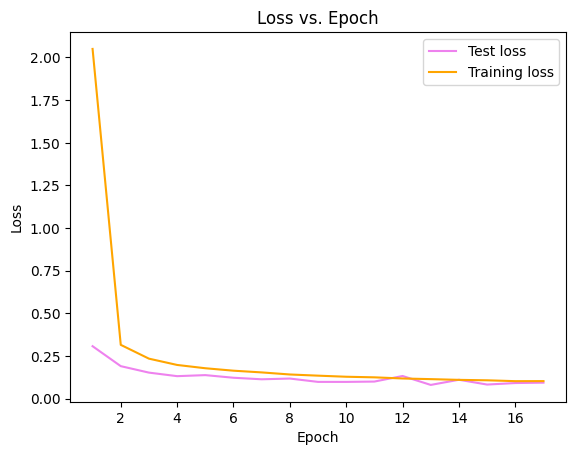

In [ ]:
def plot_loss(history):
    '''Function to plot the loss vs. epoch'''
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'violet', label = 'Test loss')
    plt.plot(x, train_loss, color='orange',label = 'Training loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')

plot_loss(history)

### A Note on Training Loss vs. Validation Loss and a Weird Thing You Might Be Noticing In The Plots

When you plotted the above, you probably wound up with a plot in which what this notebook calls the "test loss" (but which arguably may have been better called the "validation loss") actually falls *below* the training loss curve for most of the epochs.

In plotting loss curves in prior courses, you may have become used to models where we had the opposite behavior.  There you might have routinely seen gradient descent monotonically grind down the training loss (though remember with mini-batch and stochastic versions, the decline may be non-monotonic and noisy) and eventually bottom out somewhere.  In the meantime, the validation loss follows along, lagging the training loss for a while, but then bottoms out somewhere, and even starts climbing.  That divergence, where the validation loss starts to climb while the training loss is settled or still decreasing is one of the telltale signs that our training process is overfitting.  In such a case we should keep the learned weights from whichever epoch it was when the validation loss started to diverge from the training loss and call those the end point of our model.  In this notebook we used the Keras `EarlyStopping` callback to do that for us.  

Our next step then would be to see if the model's performance is satisfactory to us, and if it's not, revisit the model, and retrain a new version.  Maybe we should regularize more stringently or using a different method?  Maybe we should remove layers or units to decrease the model's capacity?  Either way, we have options to explore to reduce overfitting.

With CNNs though, you'll often see the syndrome you probably see above, and on first examination, you might find the manifestation suspicious or worrisome.  Did I accidentally mix up the inputs to the plots?  Is my model fundamentally broken?  Have I somehow chosen poorly in the methods and settings I used to try to fit the model?  Many questions like this might infest your mind at this point.

With the issue raised, let's explore a few reasons we might see the swapping of the curves.

#### Potential Cause #1: Beware Regularization That's Applied During Learning But Not During Validation and Testing!

In this course, perhaps the most common reason you see the "surprising" behavior above is when a regularization method applies during training, but not during validation and testing.  Specific to our example, recall that when dropout zeros out randomly chosen units, *dropout only does so during the training process*, for the reasons we discussed in class.  When we use the learned model for prediction or evaluation, no units are zeroed out (though there's a multiplicative boost to compensate for the units that were absent during training passes).

**TAKEAWAY:** Bake into your mind when dropout is and isn't applied, and you're less likely to be startled by such oddities in the future.  Also remember that regularization methods often sacrifice training accuracy to improve validation/testing accuracy, and we can sometimes end up with lower validation loss than training loss as a result.  The final arbiter of whether your model is working out or not is how well it does, according to your chosen metrics, when it sees new data that it hasn't been trained on.

#### Potential Cause #2: Training Loss Is Measured During Each Epoch But Validation Loss Is Measured After Each Epoch

Training loss is reported continually over the course of an epoch, but the validation metrics are computed over the validation set only after the current training epoch is completed.  As a result, the training losses are essentially being measured half an epoch earlier, on average.

If the above is what you're seeing, then shifting one of the curves by half an epoch in the suitable direction may well give you curves whose relationship looks less surprising.  Of course if you're using a regularizer like dropout, then the dropout oddity is probably going to be a bigger part of the story than the timing of reporting issue we're currently discussing.

#### Potential Cause #3: Sometimes Something Is Wonky With Your Validation Set

If the examples in the validation set are somehow easier than the examples in the training set, you'd naturally expect that the training loss might be worse than the validation loss.

Such easy-ness can creep in under a bunch of circumstances, but my favorite things to watch for are:

1. Is your validation set just plain too small?
2. Is your validation set not representative of the same distribution as your training set, i.e. are examples or classes that are somehow easier overrepresented in validation data relative to their frequency in training data?
3. Are you using data augmentation of the sort we discussed in the CNNs module? Check out your augmentation process and see if any of the transformations it's doing might be skewing the classes, creating more or fewer easy or hard examples, etc.  Data augmentation can be a useful technique, but there are ways to fool yourself with it.
4. Do you have a straight up leak of data from the training set into the validation set?  Maybe you took them both out of a larger, faulty dataset?  Maybe you partitioned training and validation examples incorrectly?  It's often a good idea to shuffle things before slicing and dicing them.  Choosing a constant seed for the shuffling process can be helpful when debugging since you know you'll be able to produce the same mixture again.

#### Potential Cause #4: Regularizing To Death

If you *over-regularize* your model, by whatever method of regularization you're using, you can also produce problems.  If you're starting to suspect that over-regularization is biasing your model too much, back off of whatever you were doing.  Maybe you were using $L^2$ regularization and could lower the $\lambda$ parameter.  Maybe you could lower your dropout probability in dropout layers (values from 0.2 to 0.5 are commonly seen, with the justification ultimately being "which one made the model work best?").  Maybe you could make your model deeper by adding layers, or fatter by putting more units in one or more layers, to boost its model capacity and give it the variance it needs to better fit the distribution.



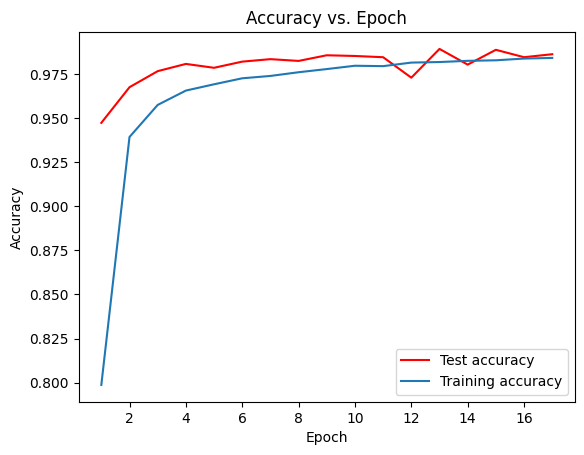

In [ ]:
def plot_accuracy(history):
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
    plt.plot(x, train_acc, label = 'Training accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')

plot_accuracy(history)

> **Exercise 2-3:** Examine these results and answer the following questions:    
> 1. How does the accuracy and error rate of your ConvNet model compare to the fully connected model for the MNIST digits problem that we uploaded to Canvas?
> 2. How can you characterize the convergence or learning rate of the ConvNet model after the first 10 epochs.     
>
> **End of Exercise**

> **Answers:**   
> 1. The test accuray and loss seem similar between the 2 models but test loss with CNN is higher. CNNs might do better with bigger and colorful images.
> 2. From the graphs, the learning rate seems cause the accuracy/loss metrics to oscillate (not smooth) after the 10th epoch. If the learning rate was smaller, maybe the network could have reached the global minima in a smoother way. We might be missing the global minima/least loss because of these bigger oscillations.

## 3.0 What features does the convolutional neural network learn?

You might well ask, what is in the various layers of the feature map? It turns out, we can actually visualize the output from each layer of the convolutional neural network to get a feel for the learned features. This can be done for both convolutional and max pooling layers.

We showed a slide in class with a picture illustrating what the intermediate feature maps look like when presented with a given input.  In the next section, you'll see how to make your own such figures by prying some information out of the model and plotting it.

As a first step we must pick an image to use as the test case. For this example, we arbitrarily choose the 13th image in the training tensor. Execute the code in the cell below to visualize this image.

(28, 28, 1)


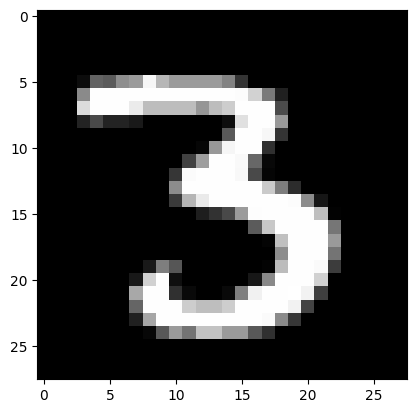

In [ ]:
img = train_images[12,:,:,:]
print(img.shape)
plt.imshow(img.reshape((28,28)), cmap = 'gray')

Our sample image turns out to be a number 3.

The code in the cell below does the following:
1. Extracts the layers from the model object into a list.
2. Creates an activation model for the set of layers using the input of the original model object and the list of layer outputs.
3. Computes the activations for each layer by applying the predict method to the activation model.

Execute this code to create a list of activations for the convolutional neural network.

In [ ]:
layer_outputs = [layer.output for layer in nn.layers[:7]]
activation_model = models.Model(inputs = nn.input, outputs = layer_outputs)
activations = activation_model.predict(img.reshape(1,28,28,1))

1/1 [==============================] - 0s 196ms/step


The code in the cell below does the following:
1. Iterates through the activations of the first 5 model layers.
2. Iterates over the activation channel in the layer displaying the image. There is one image for each channel in the feature map.

Execute this code and examine the result.

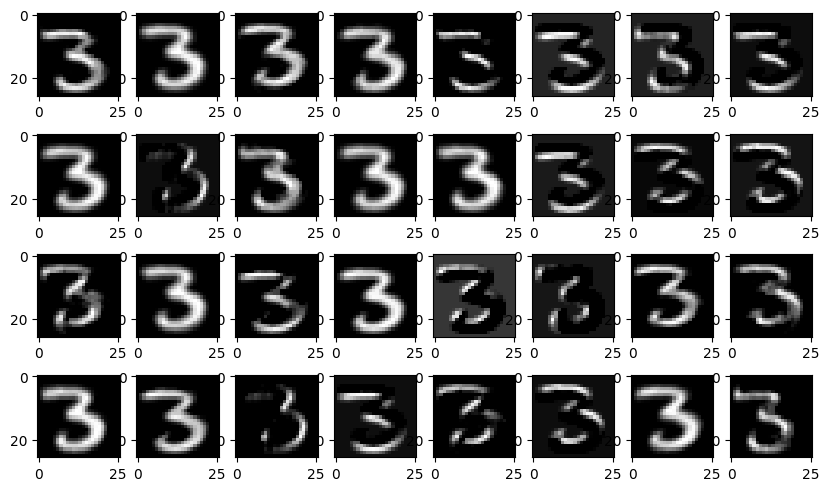

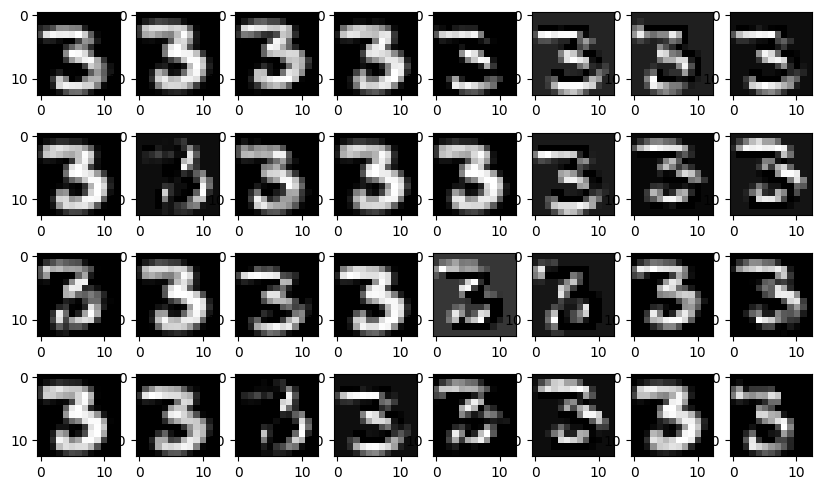

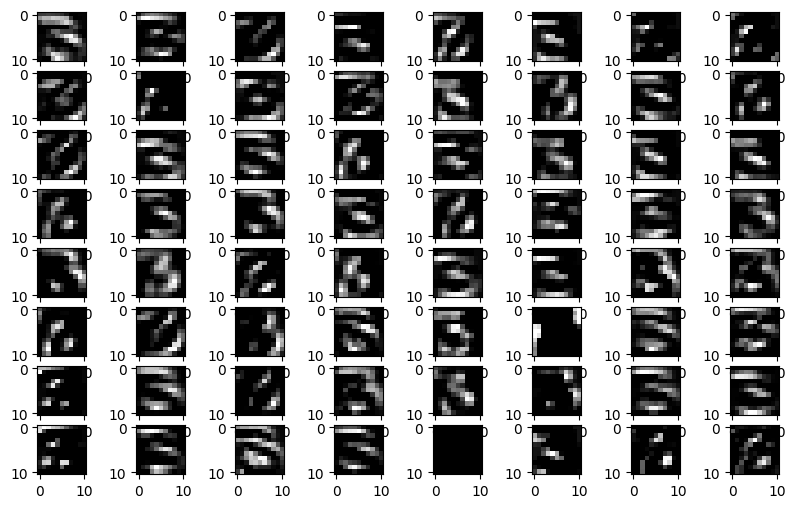

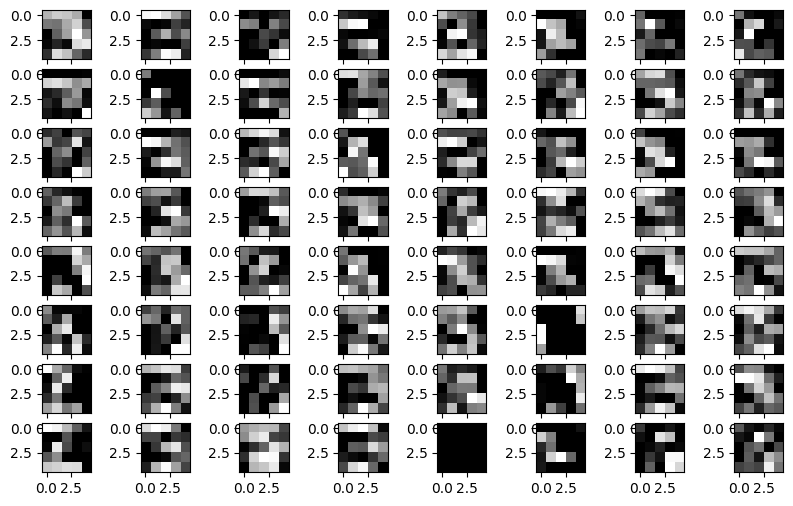

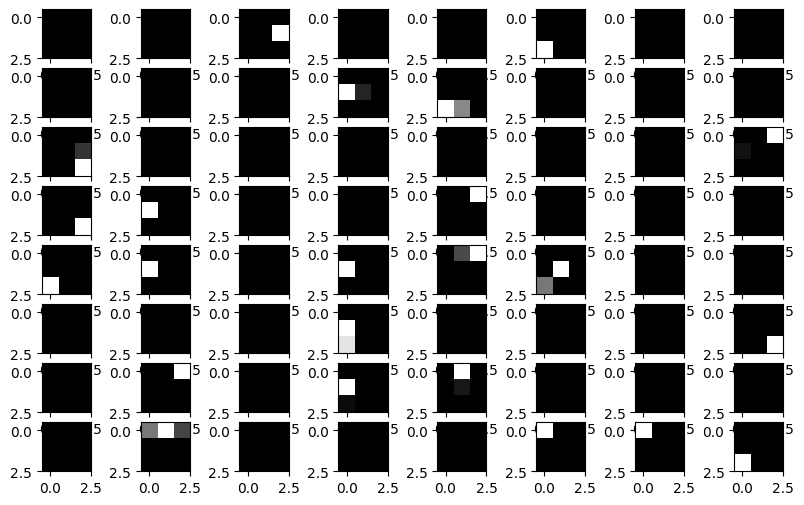

In [ ]:
for j in range(5):
    fig_shape = activations[j].shape
    s = fig_shape[3]/32
    fig = plt.figure(figsize=(10,6))
    for i in range(fig_shape[3]):
        ax = fig.add_subplot(int(s*4),8,(i+1))
        plt.imshow(activations[j].reshape((fig_shape[1],fig_shape[2],fig_shape[3]))[:,:,i], cmap='gray')

> **Exercise 2-4:** Examine the above sets of images. There are 5 sets of images, one for each of the outputs of the first 5 layers of the model. For each layer, there is an image showing one channel of the feature map.  
> 1. The initial single channel $28 \times 28 \times 1$ input image tensor becomes a $32 \times 26 \times 26 \times 1$, 32 channel feature map after the first convolution. The second $32 \times 13 \times 13 \times 1$ output is from the max-pooling layer. In general terms, describe how much this feature map resembles the original image.   
> 2. Examine the feature maps created by the third (convolution), fourth (max-pooling), and fifth (convolution) layers. How can you best describe the level of abstraction of these layers and the the resemblance to the original image?
> 3. What effect can you observe of using the max-pooling layer other than dimensionality reduction?  
> 4. What relationship can you identify between the dimensionality of the feature map and the level of abstraction of the features?
> **End of exercise**.  

> **Answers:**
> 1. The first and second sets seem close to the original. It feels like, through the different filters applied, that the network is learning how the number could look with different brightness, clarity and orientation.
> 2. The rest of the three layers seem to be microscoping and learning the different parts of the image/object to be classified. And that could be why there is no resemblance or lesser and lesser resemblance with each passing layer with the original image.
> 3. Max-pooling seems to be highlighting the edges learned through the filter.
> 4. Generally, as dimensionality decreases, abstraction should increase.

## 4.0 Padding convolution

As you have observed, each convolutional layer in a neural network reduces the spatial dimensions by $\frac{span+1}{2}$ for odd span kernels. The coverage of the convolution operator can be expanded by **zero padding** in the spatial dimension. With the zero padding added, the convolution operator covers the entire spatial dimension of the input tensor. This type of convolution is sometime referred to as **same convolution**, since the output tensor has the same spatial dimensions as the input.

In some situations, adding zero padding produces a better feature map. Zero padding allows each pixel to be visited the same number of times by the convolution operator. Without padding pixels at the edges end up being not fully represented in the feature map. More importantly, the larger feature map will have bigger model capacity.  Beyond that, depending on how big the images passing from layer to layer are, shrinkage might make things shrivel up faster than you'd really like, leaving little to pass along to deeper layers.

2D convolution with  padding is discussed in Chollet Chapter 8 if you want some discussion to supplement what we did in class.

> **Exercise 2-5:** With Keras, adding zero padding to convolutional layers is easy. The `padding = 'same'` argument adds zero padding. The default is `padding = 'valid'` which adds no padding. Create a new model, with name 'nns', with the same layers as the first model but with the `padding = same` argument for the convolutional layers.  Then print the summary of the model.

In [ ]:
## Your code goes below
nns = models.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        ## TODO
        ## Add some convolutional layers to extract features from the images.
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

        ## TODO
        ## Now flatten the output of the convolutional layers so a fully connected network can be applied.
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(l2=0.1)),
        layers.Dropout(0.5),

        ## TODO
        ## Finally, fully connected layers to classify the digits using the features extracted by the convolutional layers.
        layers.Dense(10, activation='softmax')
    ]
)

nns.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

> Examine the summary of your model and answer these questions:   
> 1. The final feature map is $64 \times 7 \times 7$, rather than $64 \times 3 \times 3$ for the model without padding. This feature map has 49 pixels per channel, compared to 9 pixels per channel previously. Do you expect that this feature map will contain more information and why?
> 2. How has the number of parameters changed for the convolutional layer, and is this expected?
> 3. Compare the number of learnable parameters for the 64 unit fully connected layer between the models with and without padding. How can you account for this difference?
> **End of exercise**.

**Answers:**   
> 1. The reduced output feature map should contain more information but I don't think we can be sure that it will contain more "useful" information because over padding is a trade-off between accuracy and efficiancy. Over padding means more trainable parameters and longer runs. Under padding means input feature map could shrink too much through the layers.
> 2. Yes, we are padding the input images to each layer with zeroes.
> 3. The trainable parameters at the Dense layer will be input (64x7x7) x 64 dense layer units along with 64 bias terms added to make it 200768 with padding where as for without padding, it is input (64x3x3) x 64 dense layer units along with 64 bias terms added to make it 36928. It's the 7x7 padding that increases the parameters in a model with padding.

Next execute the code in the cell below to compile and fit the model. This process will take some time.

In [ ]:
## Compile the model
nns.compile(optimizer = 'RMSprop', loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

## Now fit the model
history_s = nns.fit(train_images, train_labels,
                  epochs = 40, batch_size = 256,
                  validation_data = (test_images, test_labels),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 1)

Epoch 1/40
235/235 [==============================] - 4s 11ms/step - loss: 1.2724 - accuracy: 0.8128 - val_loss: 0.3453 - val_accuracy: 0.9429
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 0.3595 - accuracy: 0.9343 - val_loss: 0.2437 - val_accuracy: 0.9585
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 0.2827 - accuracy: 0.9496 - val_loss: 0.1827 - val_accuracy: 0.9793
Epoch 4/40
235/235 [==============================] - 2s 8ms/step - loss: 0.2401 - accuracy: 0.9591 - val_loss: 0.1598 - val_accuracy: 0.9794
Epoch 5/40
235/235 [==============================] - 2s 8ms/step - loss: 0.2186 - accuracy: 0.9638 - val_loss: 0.1499 - val_accuracy: 0.9820
Epoch 6/40
235/235 [==============================] - 2s 8ms/step - loss: 0.2004 - accuracy: 0.9675 - val_loss: 0.1634 - val_accuracy: 0.9741
Epoch 7/40
235/235 [==============================] - 2s 10ms/step - loss: 0.1836 - accuracy: 0.9701 - val_loss: 0.1199 - val_accuracy: 0.9866
Epoc

Next, execute the code in the cells below to plot the loss vs. epoch and accuracy vs. epoch.

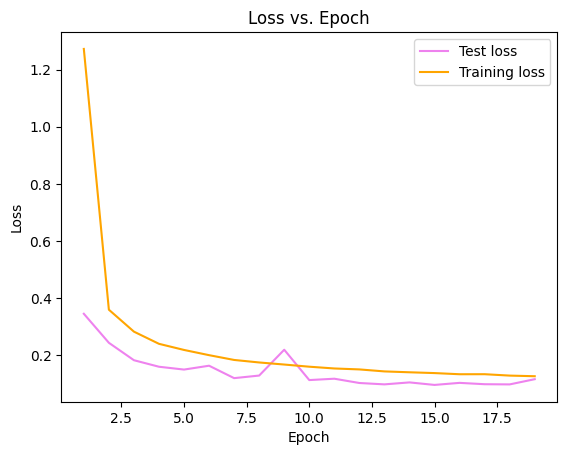

In [ ]:
plot_loss(history_s)

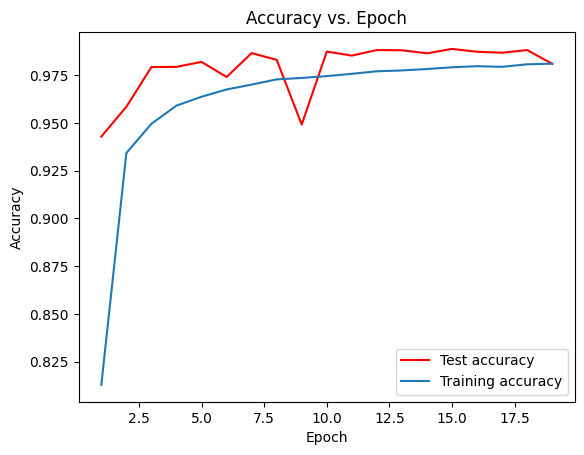

In [ ]:
plot_accuracy(history_s)

#### Copyright 2018, 2019, 2020, 2021, Stephen F Elston. All rights reserved.

#### Updates and Additions, 2023, Jerry Kuch.